## Setup database connectivity

In [3]:
%run 'database_connectivity_setup.ipynb'

Your connection object is ***`conn`***:
1. Queries: You can run your queries using ***```psql.read_sql("""<YOUR SQL>""", conn)```***.
2. Create/Delete/Updates: You can run these statements using ***```psql.execute("""<YOUR SQL>""", conn)```***, followed by a ***```conn.commit()```*** command to ensure your transaction is committed. Otherwise your changes will be rolledback if you terminate your kernel.

If you created a new connection object (say to connect to a new cluster) as shown in the last section of `database_connectivity_setup.ipynb` notebook, use that connection object where needed.

#### Import the Necessary Python Packages

In [4]:
%matplotlib inline
import cv2
import numpy as np
import urllib2
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from array import array

#### In this notebook we will demonstrate how the content-based image retrieval modeling pipeline we built in Content_Based_Image_Retrieval_in_MPP_Databases.ipynb can be used within an app to retreive similar images for a query image whose www url is passed in as input.

###### We will first create a PL/Python User Defined Function cbirapp.retrieve_similar_images that accepts an input image byte stream and runs it through the image retreival pipleline. To begin with, let us first test whether an image, given it's www url can be successfully read and pushed into the database.



In [38]:
sql = """drop function if exists cbirapp.retrieve_images(varchar) cascade;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create or replace function cbirapp.retrieve_images(img varchar)
        returns text[]
    AS
    $$
        plpy.execute("drop table if exists cbirapp.query_img cascade;")   
        plpy.execute("create table cbirapp.query_img (img varchar);")
        sqlstr = '''insert into cbirapp.query_img values ('{image}');'''.format(image=img)
        plpy.info(sqlstr)
        plpy.execute(sqlstr)
        return(['done'])
    $$ language plpythonu;
"""
psql.execute(sql,conn)
conn.commit()

In [39]:
# Let us now call the UDF on an image we read from the web.
img_req = urllib2.urlopen('http://images.huffingtonpost.com/2012-08-18-GorillaSilverback6.jpg') 
img_arr = np.asarray(bytearray(img_req.read()), dtype=np.int8)
img_arr_str = str(img_arr.tolist()).replace('[','').replace(']','')
sql = '''select cbirapp.retrieve_images('{d_arr}');'''.format(d_arr=img_arr_str)
psql.execute(sql,conn)
conn.commit()

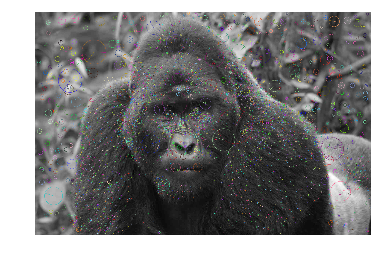

7485
128


In [40]:
# Now let us compute the SIFT features for the image we just ingested using the 
# Python binding for the OpenCV library locally in this notebook to 
# ensure our image has been stored properly
sql = """
    select
        img
    from
        cbirapp.query_img
"""

df = psql.read_sql(sql,conn)

img = df.loc[0]['img']
buf = img.split(',')
buf = map(int, buf)
buf = array('b',buf)
buf = buf.tostring()

img_arr = np.asarray(bytearray(buf), dtype=np.uint8)
im = cv2.imdecode(img_arr,-1)
gray= cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT()
kp = sift.detect(gray,None)
sift_img=cv2.drawKeypoints(gray,kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(sift_img)
plt.axis('off')
plt.show()
kp, des = sift.detectAndCompute(gray,None)
feature_vectors = des.flatten().tolist()
print des.shape[0]
print des.shape[1]

# So this works as expected.

##### Now that we have established that an image can be successfully read given it's www url and ingested into the database, let us complete the PL/Python User Defined Function cbirapp.retrieve_similar_images with the image retrieval pipeline to retrieve similar images

In [7]:
sql = """drop function if exists cbirapp.retrieve_images(varchar);"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create or replace function cbirapp.retrieve_images(img varchar)
        returns SETOF varchar
    AS
    $$
        plpy.execute("drop table if exists query_img cascade;")   
        plpy.execute("create temp table query_img (img varchar);")
        sqlstr = '''insert into query_img values ('{image}');'''.format(image=img)
        plpy.execute(sqlstr)
        
        plpy.execute("drop table if exists query_root_sift_desc;")
        sqlstr = \"""
            create temp table query_root_sift_desc as (
                select
                    cbirapp.compute_root_sift(cbirapp.SiftPLC(img)) as root_sift_descriptors
                from
                    query_img
            );
        \"""
        plpy.execute(sqlstr)
        
        plpy.execute("drop table if exists query_root_sift_cluster_assignment;")
        sqlstr = \"""
            create temp table query_root_sift_cluster_assignment as 
            (
                select 
                    data.*, 
                    (madlib.closest_column(
                        q.mean_root_sift_vectors, 
                        data.root_sift_descriptors
                    )).column_id as cluster_id
                from 
                    query_root_sift_desc as data,
                    (
                        select 
                            mean_root_sift_vectors
                        from  
                            cbirapp.training_root_sift_centroids
                    ) q
            );
        \"""
        plpy.execute(sqlstr)
        
        plpy.execute("drop table if exists query_root_sift_word_hist_table;")
        sqlstr = \"""
            create temp table query_root_sift_word_hist_table as
            (
                select
                    0::INT4 as docid, 
                    cluster_id::INT4 as wordid, 
                    count(cluster_id)::INT4 as count 
                from 
                    query_root_sift_cluster_assignment
                group by cluster_id 
            );
        \"""
        plpy.execute(sqlstr)
        
        plpy.execute("drop table if exists cbirapp.query_root_sift_lda_out_data;")
        sqlstr = \"""
            select 
                madlib.lda_predict( 
                    'query_root_sift_word_hist_table', 
                    'cbirapp.trained_root_sift_lda_model', 
                    'cbirapp.query_root_sift_lda_out_data'
                );
        \"""
        plpy.execute(sqlstr)
        
        plpy.execute("drop table if exists query_root_sift_topic_proportions")
        sqlstr = \"""
            create temp table query_root_sift_topic_proportions as 
            (
                select distinct 
                    lda_out.docid,  
                    lda_out.topic_count, 
                    madlib.array_scalar_mult(
                        lda_out.topic_count::float8[], 
                        1/(madlib.array_sum(lda_out.topic_count)::float8)
                    ) as topic_proportions
                from
                    cbirapp.query_root_sift_lda_out_data lda_out, 
                    query_root_sift_word_hist_table as hist_table
                where 
                    hist_table.docid = lda_out.docid
            );
        \"""
        plpy.execute(sqlstr)
        
        plpy.execute("drop table if exists query_root_sift_knn_retrieval;")
        sqlstr = \"""
            create temp table query_root_sift_knn_retrieval as
            (
                select
                    lda_train.img_name as train_img_name, 
                    madlib.array_dot(
                        lda_test.topic_proportions, 
                        lda_train.topic_proportions
                    )/(
                        madlib.norm2(lda_test.topic_proportions)*
                        madlib.norm2(lda_train.topic_proportions)
                    ) as cosine_similarity
                from
                    query_root_sift_topic_proportions as lda_test, 
                    cbirapp.training_root_sift_topic_proportions as lda_train
            );
        \"""
        plpy.execute(sqlstr)
        
        sqlstr = \"""
            select
                t.img
            from
                cbirapp.training_images t,
                (
                    select
                        train_img_name
                    from (
                        select
                            ROW_NUMBER() over (order by cosine_similarity DESC) AS RowNumber,
                            train_img_name
                        from
                            query_root_sift_knn_retrieval
                    ) inner_query
                    where RowNumber <= 9
                ) q
            where t.img_name = q.train_img_name
        \"""
        rv = plpy.execute(sqlstr)
        return rv
    $$ language plpythonu;
"""
psql.execute(sql,conn)
conn.commit()

In [5]:
img_req = urllib2.urlopen('http://images.huffingtonpost.com/2012-08-18-GorillaSilverback6.jpg') 
img_arr = np.asarray(bytearray(img_req.read()), dtype=np.int8)
img_arr_str = str(img_arr.tolist()).replace('[','').replace(']','')
sql = '''select cbirapp.retrieve_images('{d_arr}');'''.format(d_arr=img_arr_str)
result = psql.execute(sql,conn)
images = result.fetchall()
result.close()

#### We now render the 9 most similar images and you have your image recommender!

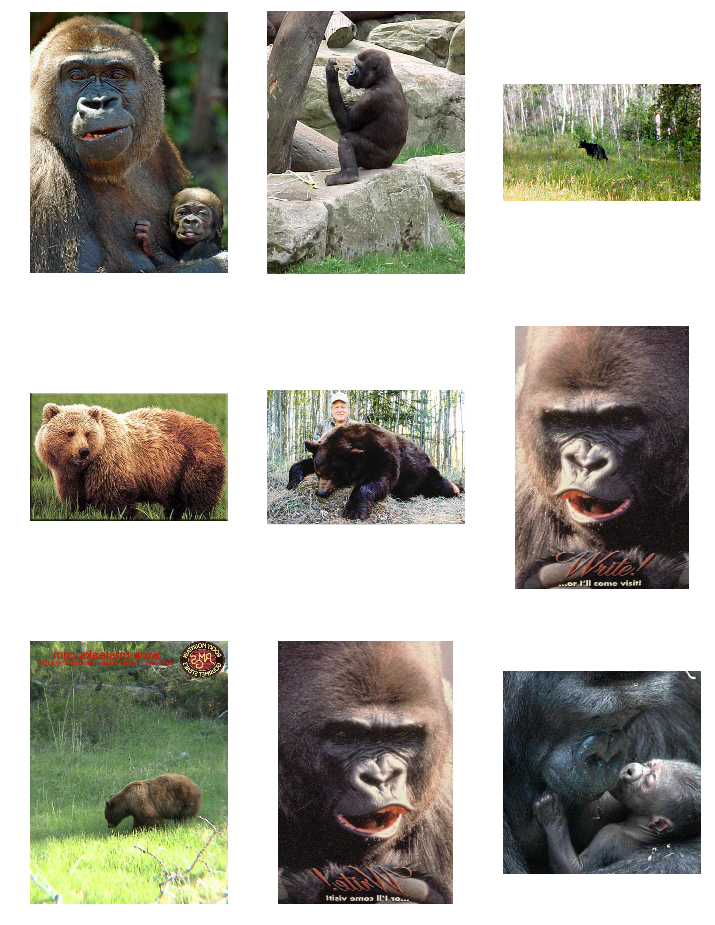

In [9]:
import ast
from PIL import Image
import StringIO
f, axarr = plt.subplots(3,3)
f.patch.set_facecolor('white')
f.set_size_inches(12,16)
for i in range(0, 9):
    I = images[i]
    image = ast.literal_eval(I[0])['img']
    buf = image.split(',')
    buf = map(int, buf)
    buf = array('b',buf)
    buf = buf.tostring()
    buff = StringIO.StringIO() 
    buff.write(buf)
    buff.seek(0)
    im = Image.open(buff)
    if (i % 3 == 0):
        j = 0
    if (i < 3):
        axarr[0, j].imshow(im)
        axarr[0, j].axis('off')
        j = j + 1
    elif (i >=3 and i < 6):
        axarr[1, j].imshow(im)
        axarr[1, j].axis('off')
        j = j + 1
    elif (i >= 6 and i < 9):
        axarr[2, j].imshow(im)
        axarr[2, j].axis('off')
        j = j + 1
plt.show()

In [8]:
# Close DB connection
conn.close()